In [68]:
import pandas as pd
time_series = pd.read_csv('time_series.csv')
# drop_na = pd.read_csv('drop_na.csv')

In [69]:
time_series

,geo_value,time_value,change_health,hospital_admit,doc_visits,ground_truth,ground_truth+1,change_health-1,hospital_admit-1,doc_visits-1
0,6001,2020-03-02,0.013988,0.119067,0.000000,0.0,1.0,0.011162,0.119646,0.000000
1,6003,2020-03-02,0.079448,0.179150,0.108915,0.0,0.0,0.076868,0.192803,0.093681
2,6005,2020-03-02,0.129362,0.179150,0.000000,0.0,0.0,0.125200,0.192803,0.000000
3,6007,2020-03-02,0.049212,0.179150,0.000000,0.0,0.0,0.053394,0.192803,0.000000
4,6009,2020-03-02,0.367170,0.179150,0.108915,0.0,0.0,0.354651,0.192803,0.093681
...,...,...,...,...,...,...,...,...,...,...
20379,6107,2021-02-28,0.812549,3.600349,5.598161,35.0,36.0,0.856947,3.716032,6.073696
20380,6109,2021-02-28,0.630288,3.600349,3.483553,1.0,3.0,0.566797,3.716032,2.858993
20381,6111,2021-02-28,0.315021,5.087297,2.901180,100.0,72.0,0.344551,5.402339,3.278830
20382,6113,2021-02-28,0.370449,3.600349,3.906626,7.0,12.0,0.315869,3.716032,4.228532


In [72]:
import numpy as np

dates = time_series['time_value'].unique()
dates_length = len(dates)
test_split = int(0.95*dates_length)

train_row = dates[:test_split]
test_row = dates[test_split:]

train = time_series.loc[time_series['time_value'].isin(train_row), :]#.set_index('time_value')
test = time_series.loc[time_series['time_value'].isin(test_row), :]#.set_index('time_value')

columns = time_series.columns
columns = np.append(columns, columns[6])
columns = np.delete(columns, [0,1,6])

X_train = train.loc[:, columns[:-1]]
y_train = train.loc[:, columns[-1]]
X_test = test.loc[:, columns[:-1]]
y_test = test.loc[:, columns[-1]]

### Simple Model

In [75]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.tree import DecisionTreeRegressor
import numpy as np

tree_depths = range(2,17)
tscv = TimeSeriesSplit(n_splits=7)
train_avg = []
valid_avg = []
test_avg = []
for depth in tree_depths:
    dtree = DecisionTreeRegressor(max_depth=depth, random_state=0)
    cv_score = cross_validate(dtree, X_train, y_train, cv=tscv, scoring='r2', return_train_score=True)
    train_avg.append(cv_score['train_score'].mean())
    valid_avg.append(cv_score['test_score'].mean())
    
    tests = []
    for i, (train_index, validate_index) in enumerate(tscv.split(X_train)):
        temp_X_train = X_train.iloc[train_index]
        temp_y_train = y_train.iloc[train_index]
        temp_X_valid = X_train.iloc[validate_index]
        temp_y_valid = y_train.iloc[validate_index]
        
        dtree = DecisionTreeRegressor(max_depth=depth, random_state=0)
        dtree.fit(temp_X_train, temp_y_train)
        tests.append(dtree.score(X_test, y_test))
        
    test_avg.append(np.mean(tests))

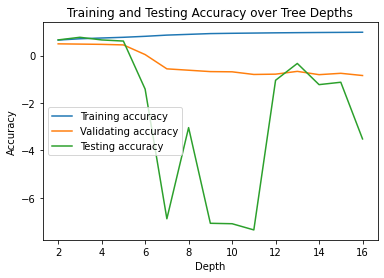

In [76]:
import matplotlib.pyplot as plt

plt.plot(tree_depths, train_avg, label='Training accuracy')
plt.plot(tree_depths, valid_avg, label='Validating accuracy')
plt.plot(tree_depths, test_avg, label='Testing accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Tree Depths')
plt.legend()
plt.show()

In [83]:
# max_index = np.argmax(test_avg)
max_index = np.argmax(valid_avg)
dtree = DecisionTreeRegressor(max_depth=tree_depths[3])
dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

0.8845159049463991

In [157]:
predictions = dtree.predict(X_test)

In [158]:
from sklearn.metrics import mean_squared_error as MSE

MSE(y_test, predictions)

18427.772883175643

In [127]:
pred_county_A = predictions[::len(time_series['geo_value'].unique())]
county_A = test.loc[test['geo_value']==6001, columns[-1]]

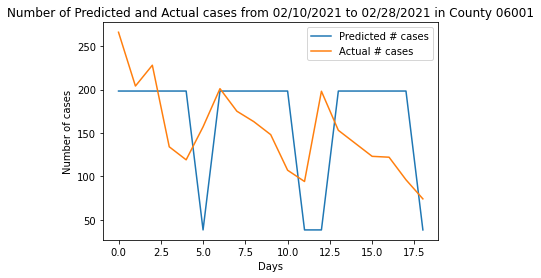

In [128]:
import matplotlib.pyplot as plt

plt.plot(range(19), pred_county_A, label='Predicted # cases')
plt.plot(range(19), county_A, label='Actual # cases')
plt.xlabel('Days')
plt.ylabel('Number of cases')
plt.title('Number of Predicted and Actual cases from 02/10/2021 to 02/28/2021 in County 06001')
plt.legend()
plt.show()

In [131]:
pred_county_B = predictions[3::len(time_series['geo_value'].unique())]
county_B = test.loc[test['geo_value']==6007, columns[-1]]

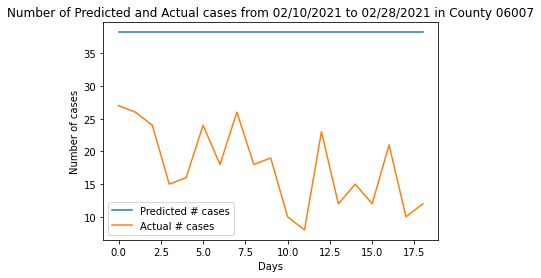

In [133]:
import matplotlib.pyplot as plt

plt.plot(range(19), pred_county_B, label='Predicted # cases')
plt.plot(range(19), county_B, label='Actual # cases')
plt.xlabel('Days')
plt.ylabel('Number of cases')
plt.title('Number of Predicted and Actual cases from 02/10/2021 to 02/28/2021 in County 06007')
plt.legend()
plt.show()

### Complex model

In [165]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)
print('Done')

Done


In [166]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

tscv = TimeSeriesSplit(n_splits=7)
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}
grid = GridSearchCV(estimator=SVR(), cv=tscv, param_grid=param_grid,
                    refit=True, scoring='r2', return_train_score=True)
grid.fit(X_train_scaled, y_train)
print('Done')

Done


In [167]:
best_model = grid.best_estimator_
print(best_model)
print(grid.best_score_)

SVR(C=100, gamma=0.1)
0.3718790446788783


In [168]:
predictions = best_model.predict(X_test_scaled)

In [169]:
from sklearn.metrics import mean_squared_error as MSE

MSE(y_test, predictions)

88549.50771565991

In [170]:
pred_county_A = predictions[::len(time_series['geo_value'].unique())]
county_A = test.loc[test['geo_value']==6001, columns[-1]]

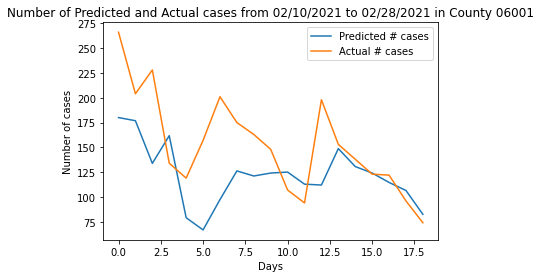

In [104]:
import matplotlib.pyplot as plt

plt.plot(range(19), pred_county_A, label='Predicted # cases')
plt.plot(range(19), county_A, label='Actual # cases')
plt.xlabel('Days')
plt.ylabel('Number of cases')
plt.title('Number of Predicted and Actual cases from 02/10/2021 to 02/28/2021 in County 06001')
plt.legend()
plt.show()

In [171]:
pred_county_B = predictions[3::len(time_series['geo_value'].unique())]
county_B = test.loc[test['geo_value']==6007, columns[-1]]

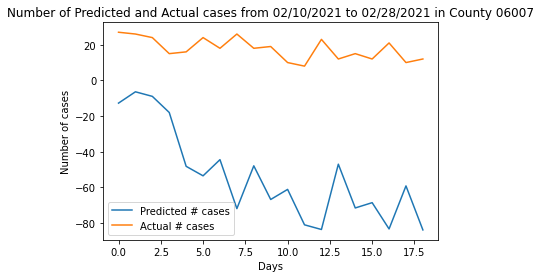

In [172]:
import matplotlib.pyplot as plt

plt.plot(range(19), pred_county_B, label='Predicted # cases')
plt.plot(range(19), county_B, label='Actual # cases')
plt.xlabel('Days')
plt.ylabel('Number of cases')
plt.title('Number of Predicted and Actual cases from 02/10/2021 to 02/28/2021 in County 06007')
plt.legend()
plt.show()